# Import needed modules

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create needed functions

## Functions to Create Data Frame from Dataset

#### **Function to create data frame**

In [2]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        # check the folders from main directory. If there are another files, ignore them
        if pathlib.Path(foldpath).suffix != '':
            continue

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            # check if there are another folders
            if pathlib.Path(foldpath).suffix == '':
                # check unneeded masks
                if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                    continue

                else:
                    o_file = os.listdir(fpath)
                    for f in o_file:
                        ipath = os.path.join(fpath, f)
                        filepaths.append(ipath)
                        labels.append(fold)

            else:
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

#### Function to generate images from dataframe

In [3]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [4]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Callbacks**
<br>
Callbacks : Helpful functions to help optimize model training  <br>
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

#### **Function to plot history of training**

In [6]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


#### **Function to create Confusion Matrix**

In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [8]:
# If you're on Google Colab, you can upload your kaggle.json file using the following code
from google.colab import files
files.upload()  # Choose kaggle.json to upload

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tony1241","key":"5585cbdbeeb5bf8cc2b8d49b6bd8e599"}'}

In [9]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:

!pip install kaggle

In [11]:
# Replace 'nunenuh/pytorch-challange-flower-dataset' with the correct dataset path from Kaggle
!kaggle datasets download tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 98% 766M/778M [00:06<00:00, 155MB/s]
100% 778M/778M [00:06<00:00, 121MB/s]


In [12]:
import zipfile
with zipfile.ZipFile("/content/covid19-radiography-database.zip", 'r') as zip_ref:
    zip_ref.extractall("coviddata")

# **Model Structure**

#### **Start Reading Dataset**

In [25]:
data_dir = '/content/coviddata/COVID-19_Radiography_Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 16
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [26]:
import os
import shutil

# Path for saving the test images
output_test_dir = '/content/coviddata/test'

# Function to copy test images to the separate folder
def save_test_images_from_generator(generator, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)  # Create folder if it doesn't exist

    # Loop through the generator's batches to get filepaths
    test_filepaths = generator.filepaths  # This attribute contains the full paths of the test images

    for img_path in test_filepaths:
        # Extract filename
        img_filename = os.path.basename(img_path)
        # Copy the image to the new directory
        shutil.copy(img_path, os.path.join(target_dir, img_filename))

    print(f"All test images have been saved to {target_dir}")

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 16
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

    # Save test images to the separate folder
    save_test_images_from_generator(test_gen, output_test_dir)

except Exception as e:
    print('Error:', e)

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.
All test images have been saved to /content/coviddata/test


In [27]:
import os
import shutil

# Path for saving the validation images
output_valid_dir = '/content/coviddata/valid'

# Function to copy validation images to the separate folder
def save_validation_images_from_generator(generator, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)  # Create folder if it doesn't exist

    # Loop through the generator's batches to get filepaths
    valid_filepaths = generator.filepaths  # This attribute contains the full paths of the validation images

    for img_path in valid_filepaths:
        # Extract filename
        img_filename = os.path.basename(img_path)
        # Copy the image to the new directory
        shutil.copy(img_path, os.path.join(target_dir, img_filename))

    print(f"All validation images have been saved to {target_dir}")

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 16
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

    # Save validation images to the separate folder
    save_validation_images_from_generator(valid_gen, output_valid_dir)

except Exception as e:
    print('Error:', e)

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.
All validation images have been saved to /content/coviddata/valid


In [34]:
import os
import shutil
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define paths for source folders and target folders in Google Drive
test_folder = '/content/coviddata/test'  # Replace with your actual test folder path
valid_folder = '/content/coviddata/valid'  # Replace with your actual valid folder path

# Define target folders in Google Drive
google_drive_path = '/content/drive/MyDrive/saved_data'
test_drive_folder = os.path.join(google_drive_path, 'test_gen')
valid_drive_folder = os.path.join(google_drive_path, 'valid_gen')

# Step 3: Function to copy folders to Google Drive
def copy_folder_to_drive(src_folder, dest_folder):
    if not os.path.exists(src_folder):
        print(f"Source folder not found: {src_folder}")
        return
    if os.path.exists(dest_folder):
        print(f"Deleting existing folder: {dest_folder}")
        shutil.rmtree(dest_folder)  # Delete existing folder
    shutil.copytree(src_folder, dest_folder)
    print(f"Folder copied successfully to: {dest_folder}")

# Ensure Google Drive directory exists
if not os.path.exists(google_drive_path):
    os.makedirs(google_drive_path)

# Step 4: Copy test_gen and valid_gen folders
try:
    # Copy test_gen folder
    copy_folder_to_drive(test_folder, test_drive_folder)

    # Copy valid_gen folder
    copy_folder_to_drive(valid_folder, valid_drive_folder)

except Exception as e:
    print(f"Error copying folders: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder copied successfully to: /content/drive/MyDrive/saved_data/test_gen
Folder copied successfully to: /content/drive/MyDrive/saved_data/valid_gen


#### **Display Image Sample**

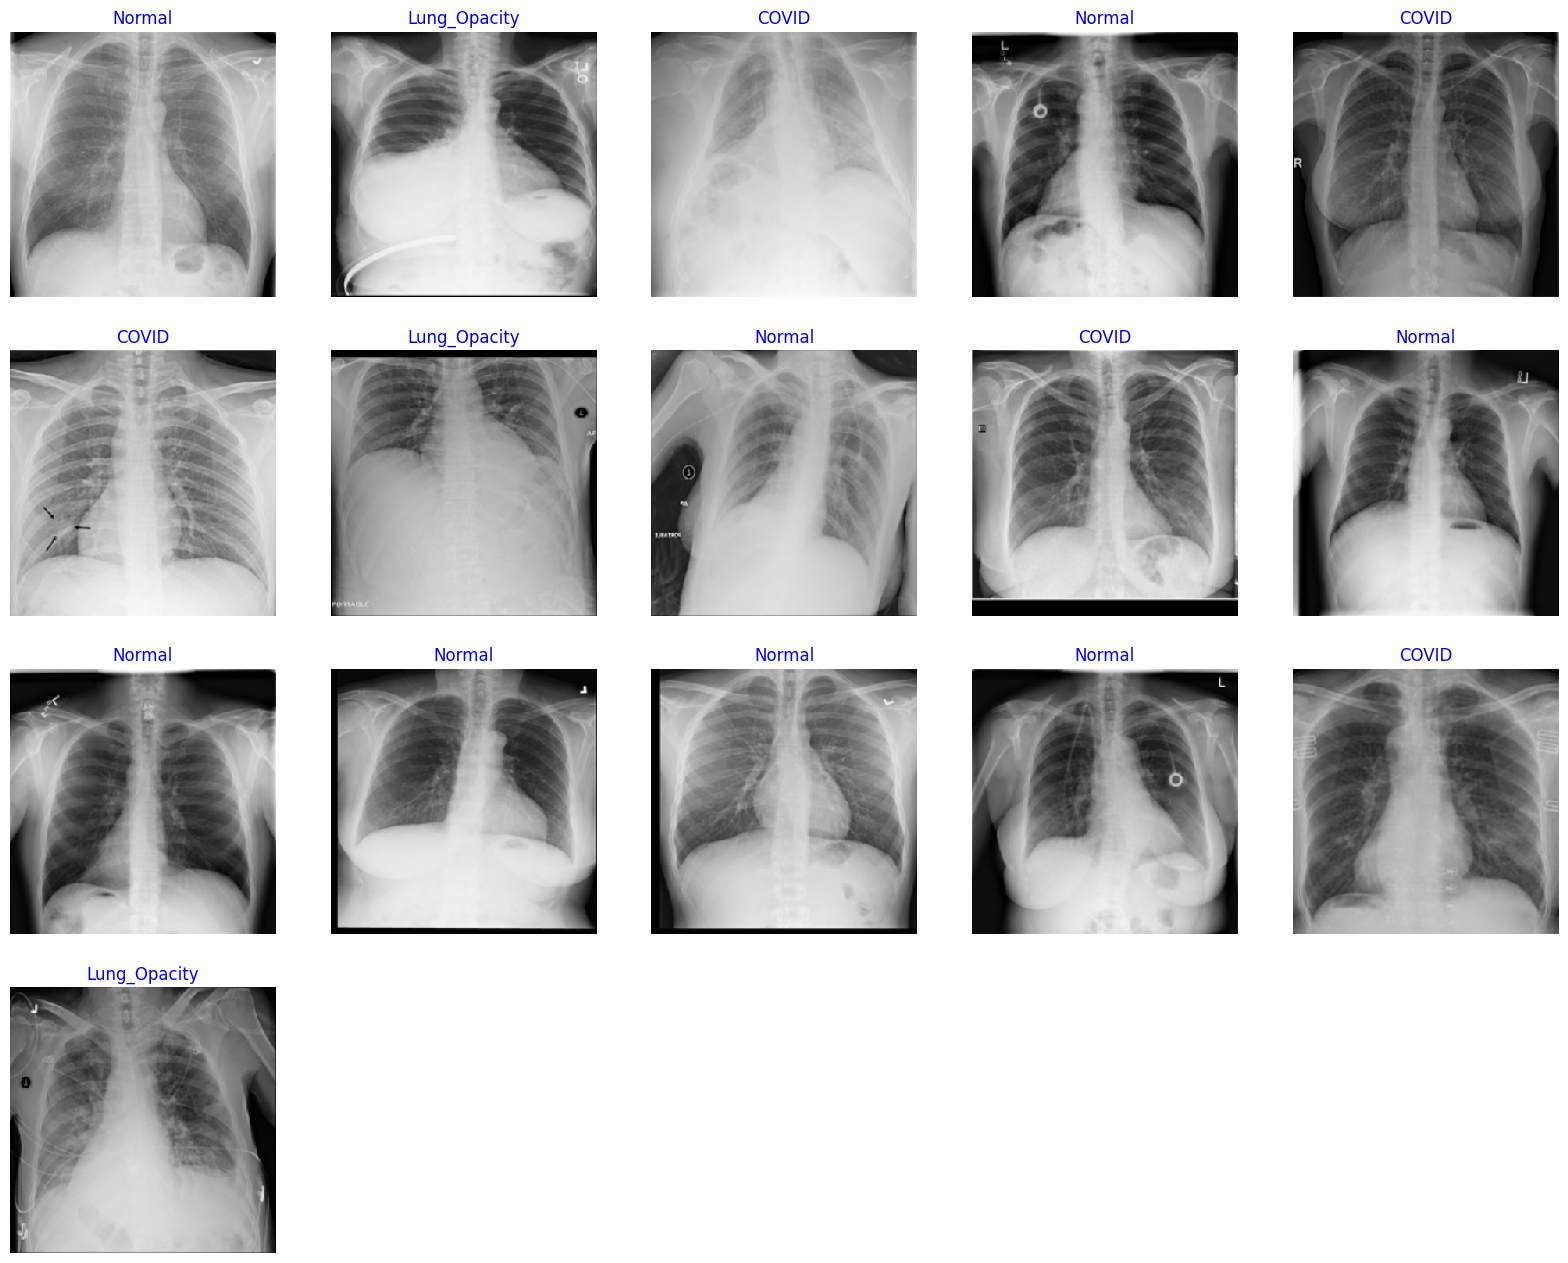

In [28]:
show_images(train_gen)

#### **Generic Model Creation**

In [29]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.vgg19.VGG19(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                                 
Total params: 20026436 (76.39 MB)
Trainable params: 20026436 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.wait = 0  # Counter for patience
        self.best = float('inf')  # Best loss value
        self.stopped_epoch = 0  # Track stopping epoch

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get("val_loss")
        accuracy = logs.get("accuracy")

        print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

        if val_loss is not None and val_loss < self.best:
            self.best = val_loss
            self.wait = 0  # Reset patience counter
        else:
            self.wait += 1  # Increment patience counter

        # Stop training if patience exceeded
        if self.wait >= self.stop_patience:
            print(f"Stopping training at epoch {epoch+1}")
            self.stopped_epoch = epoch
            self.model.stop_training = True

#### **Set Callback Parameters**

In [31]:
batch_size = 16   # set batch size for training
epochs = 100   # number of all epochs in training
patience = 3   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 10   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

#### **Train model**

In [32]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

KeyboardInterrupt: 

#### **Display model performance**

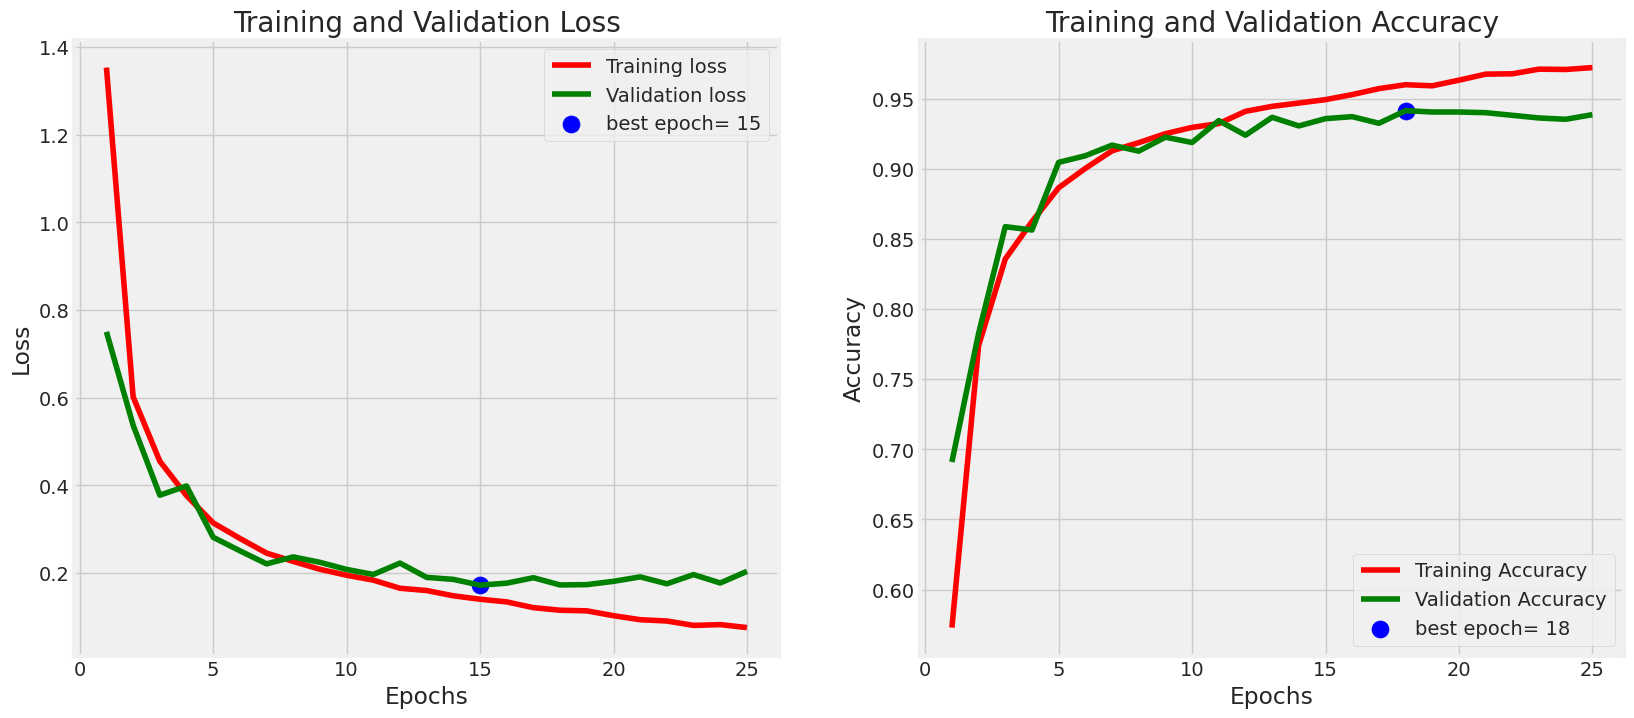

In [ ]:
plot_training(history)

# **Evaluate model**

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9622 - loss: 0.0918
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9109 - loss: 0.2784
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 372ms/step - accuracy: 0.9197 - loss: 0.2436
Train Loss:  0.07396512478590012
Train Accuracy:  0.9676724076271057
--------------------
Validation Loss:  0.23006100952625275
Validation Accuracy:  0.9245689511299133
--------------------
Test Loss:  0.21821889281272888
Test Accuracy:  0.9305621385574341


# **Get Predictions**

In [ ]:
preds = model.predict(test_gen)  # Use predict instead of predict_generator
y_pred = np.argmax(preds, axis=1)
print(y_pred)

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 325ms/step
[1 1 2 ... 1 2 2]


#### **Confusion Matrics and Classification Report**

Confusion Matrix, Without Normalization
[[350   8   3   1]
 [  8 514  80   0]
 [  7  26 980   6]
 [  3   0   5 126]]
                 precision    recall  f1-score   support

          COVID       0.95      0.97      0.96       362
   Lung_Opacity       0.94      0.85      0.89       602
         Normal       0.92      0.96      0.94      1019
Viral Pneumonia       0.95      0.94      0.94       134

       accuracy                           0.93      2117
      macro avg       0.94      0.93      0.93      2117
   weighted avg       0.93      0.93      0.93      2117



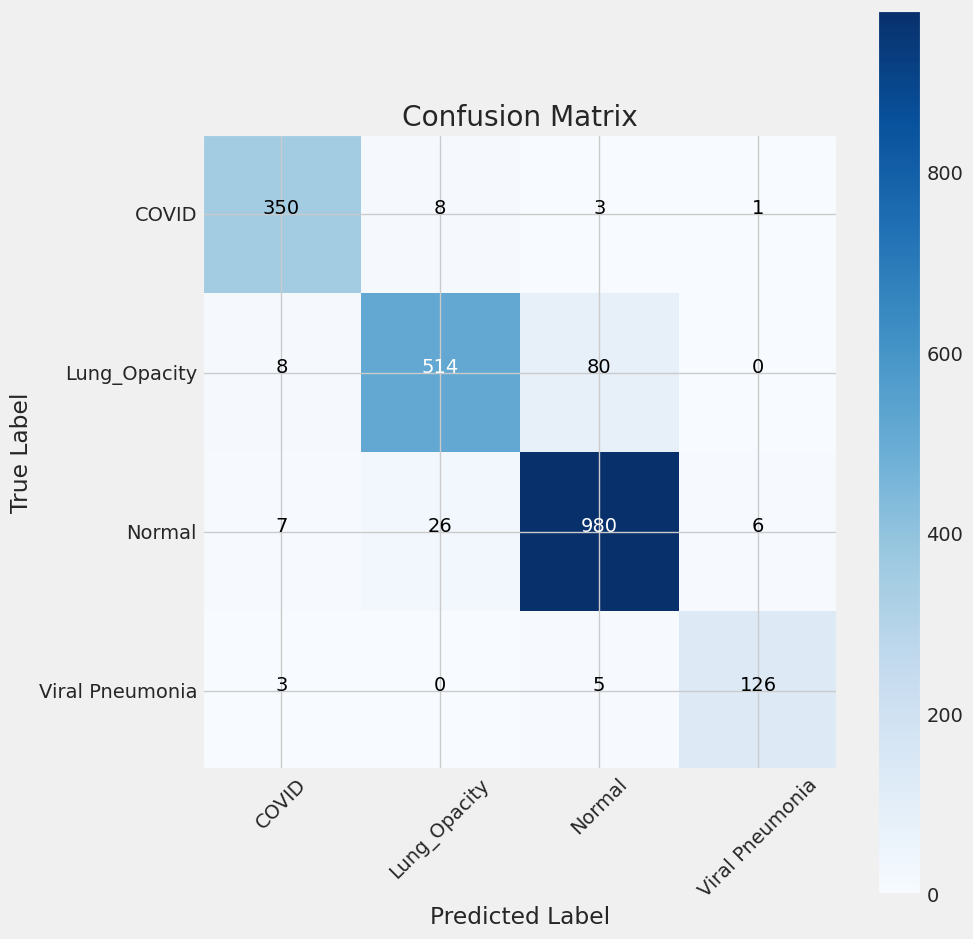

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

#### **Save model**

#### **Generate CSV files containing classes indicies & image size**

In [ ]:
# Save the model
model_save_path = "content/covid19_vgg19_model.h5"
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Model saved at: content/covid19_vgg19_model.h5


In [ ]:
# Save weights only
weights_save_path = "/content/covid19_vgg19_model.weights.h5"
model.save_weights(weights_save_path)
print(f"Model weights saved at: {weights_save_path}")

Model weights saved at: /content/covid19_vgg19_model.weights.h5


In [ ]:
import pickle

# Save the model using pickle
with open("covid19_vgg19_model.pkl", "wb") as f:
    pickle.dump(model.to_json(), f)  # Save the model's architecture as JSON
    print("Model architecture saved as pickle file.")

Model architecture saved as pickle file.


In [ ]:
from tensorflow.keras.models import model_from_json

# Load model architecture
with open("covid19_vgg19_model.pkl", "rb") as f:
    model_architecture = pickle.load(f)

# Reconstruct the model
loaded_model = model_from_json(model_architecture)
loaded_model.load_weights("/content/content/covid19_vgg19_model.h5")  # Load weights
print("Model reloaded successfully.")

Model reloaded successfully.
